In [1]:
import os
import json
import numpy as np
import pandas as pd
import geopandas as gpd
import seaborn as sns
import matplotlib.pyplot as plt
import folium
from folium.plugins import MarkerCluster


## Load geodataframe

### Country origins

In [2]:
country_ISO = 'TUN'
country_csv = pd.read_csv('../data/wbccodes2014.csv')
country_full = country_csv.set_index('country').loc[country_ISO,'country_name']
geodf = gpd.read_file('../src/%s/output/%s/%s.shp'%(country_ISO,country_full,country_full))
centroids = geodf.to_crs(epsg=4326).unary_union.centroid
lat,lon = centroids.x,centroids.y

## Qty of interest distribution

Plotting any quantity of interest distribution to get a grasp of what to expect from the mapping and how to tweak it to make it more expressive

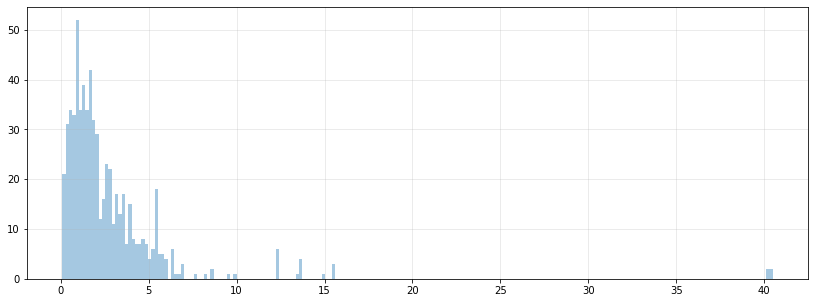

In [3]:
qty_interest = 't_hospital'

plt.figure(figsize=(14, 5))
sns.distplot(geodf[qty_interest].values, bins=len(geodf) // 3, kde=False)
plt.grid(alpha=0.3)
plt.show()

### Hospitals

In [4]:
hospitals = gpd.read_file('../src/%s/output/hospitals.shp'%(country_ISO))
hospitals['lon'] = hospitals.geometry.apply(lambda z : z.x)
hospitals['lat'] = hospitals.geometry.apply(lambda z : z.y)
locationlist = hospitals[['lat', 'lon']].values.tolist()

## Option 1 : Visualizing as Folium Choropleth

In [13]:
from shapely.geometry import point, polygon

__Transform parsing windows as polygons__

In [15]:
def make_polygon(row):
    p = polygon.Polygon(shell=[(row['left_lon'], row['top_lat']),
                               (row['left_lon'], row['bottom_lat']),
                               (row['right_lon'], row['bottom_lat']),
                               (row['right_lon'], row['top_lat'])])
    row['geometry'] = p
    return row


p_geodf = geodf.apply(make_polygon, axis=1)

__Add index as columns for jointure of Polygon X Qty of interest under Choropeth layer__

In [16]:
p_geodf.reset_index(level=0, inplace=True)
p_geodf.sample(n=1)

,index,window,left_x,right_x,top_y,bottom_y,left_lon,top_lat,right_lon,bottom_lat,center_lon,center_lat,count,nancount,tot_pop,split,t_hospital,so_hospita,geometry
512,512,200,3400,3600,2200,2400,10.364167,35.726667,10.530833,35.56,10.4475,35.643333,40000,40000,13468.743164,1,0.902556,977.866051,"POLYGON ((10.36417 35.72667, 10.36417 35.56000..."


__Define Choropeth layer__

In [17]:
# Define GeoJson geometric file and name qty of interest to plot
geo_data = json.loads(p_geodf.to_json())
qty_interest = 't_hospital'

# Manually hard set max threshold for qty of interest value (for map expressivness)
max_value = p_geodf[qty_interest].quantile(0.9)
p_geodf[qty_interest] = p_geodf[qty_interest].clip(upper=max_value)

# Layer colors and legends
fill_color = 'OrRd'
fill_opacity = 0.3,
line_opacity = 0.2,
legend_name = 'Traffic time to closest hospital (h)'

choropeth_kwargs = {'geo_data': geo_data,
                    'name': qty_interest,
                    'data': p_geodf,
                    'columns': ['index', qty_interest],
                    'key_on': 'feature.properties.index',
                    'fill_color': fill_color,
                    'fill_opacity': fill_opacity,
                    'line_opacity': line_opacity,
                    'legend_name': legend_name}

layer = folium.Choropleth(**choropeth_kwargs)

In [43]:
m = folium.Map(
    location=[lon,lat],
    tiles='cartodbpositron',
    zoom_start=6
)

layer.add_to(m)

m.save('../src/%s/output/heatmap_%s.html'%(country_ISO,country_ISO))

m

## Option 2 : Visualizing as Folium Heatmap

In [5]:
import branca
from folium.plugins import HeatMap

In [6]:
# Longitude/Latitude and Qty of interest columns names
lat_name = 'center_lat'
lon_name = 'center_lon'
qty_interest = 't_hospital'


# Serie to plot as heatmap
serie = geodf[qty_interest]

# Heatmap hyperparameters
max_heatmap_value = 2
radius = 5
blur = 1
min_opacity = 0.1
max_zoom = 6

# Heatmap colorscale
n_gradient_steps = 5
colorscale = branca.colormap.linear.viridis.scale(0, 1)
color_gradient = {x: colorscale(x) for x in np.linspace(0, 1, n_gradient_steps)}

# Legend colorscale != from heatmap colorscale (heatmaps uses [0, 1] range)
legend_colorscale = branca.colormap.linear.viridis.scale(serie.min(), max_heatmap_value)
legend_colorscale.caption = 'Traffic time to closest hospital (h)'

In [7]:
heatmap_kwargs = {'data': geodf[[lat_name, lon_name, qty_interest]].values.tolist(),
                  'name': serie.name,
                  'min_opacity': min_opacity,
                  'max_zoom': max_zoom,
                  'max_val': max_heatmap_value,
                  'radius': radius,
                  'blur': blur,
                  'gradient': color_gradient
                 }

heatmap = HeatMap(**heatmap_kwargs)

In [9]:
m = folium.Map(
    location=[lon,lat],
    tiles='cartodbpositron',
    zoom_start=6.5
    )

marker_cluster = MarkerCluster().add_to(m)

for point in range(0, len(locationlist)):
    folium.Marker(locationlist[point], popup='Hospital', icon=\
                  folium.Icon(color='red', icon_color='white', icon='ambulance', angle=0, prefix='fa')).add_to(marker_cluster)

heatmap.add_to(m)

m.add_child(legend_colorscale)
m.save('../src/%s/output/choropleth_%s.png'%(country_ISO,country_ISO))
m